In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
import datetime
import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from analyses_code import gisaid_visualisation

from dateutil.relativedelta import relativedelta
from datetime import datetime

## Data preprocessing

### Downloaded metadata from GISAID (dates and locations only)

In [2]:
full_data = pd.read_csv('./gisaid_output/dates_and_locations_2022_04_19.tsv',sep='\t')

full_data['Continent'] = list(map(lambda x:x.split('/')[0].strip(),full_data['Location']))
full_data['Country'] = list(map(lambda x:x.split('/')[1].strip(),full_data['Location']))

full_data['Collection date'] = pd.to_datetime(full_data['Collection date'])
full_data['Submission date'] = pd.to_datetime(full_data['Submission date'])
full_data['Lags'] = full_data['Submission date'] - full_data['Collection date']
full_data['Lags'] = full_data['Lags'].dt.days
full_data['Collection_Month'] = full_data['Collection date'].dt.strftime('%Y-%b')


full_data = full_data[full_data['Host']=='Human'].drop(['Type','Is reference?', 'Is complete?', 'Is high coverage?',
       'Is low coverage?', 'N-Content', 'GC-Content'],axis=1)

full_data = full_data.drop(index=full_data[full_data['Continent'] == 'NA'].index)

C:\Users\Le.Hai\.conda\envs\py39\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [58]:
full_data.to_csv('./dataset/preprocessed_data/full_data_date_and_location_gisaid.csv',index=False)

In [2]:
full_data =  pd.read_csv('./dataset/preprocessed_data/full_data_date_and_location_gisaid.csv')

### Downloaded full metadata from GISAID

In [33]:
full_data = pd.read_csv('./gisaid_output/metadata_04_04_22.csv',header=[1])
full_data = full_data[~full_data[['Location','Host','Collection date','Submission date']].isna().any(axis=1)]
full_data['Continent'] = list(map(lambda x:x.split('/')[0].strip(),full_data['Location']))
full_data['Country'] = list(map(lambda x:x.split('/')[1].strip(),full_data['Location']))

full_data['Collection date'] = pd.to_datetime(full_data['Collection date'])
full_data['Submission date'] = pd.to_datetime(full_data['Submission date'])
full_data['Lags'] = full_data['Submission date'] - full_data['Collection date']
full_data['Lags'] = full_data['Lags'].dt.days
full_data['Collection_Month'] = full_data['Collection date'].dt.strftime('%Y-%b')

In [35]:
full_data.to_csv('./dataset/preprocessed_data/full_metadata_04_04_22.csv',index=False)

In [2]:
full_data = pd.read_csv('./dataset/preprocessed_data/full_metadata_04_04_22.csv')

In [3]:
full_data = full_data[full_data['Host'] == 'Human']

## Plot 1: Mean lags per month

In [32]:
full_data_continent_by_month = gisaid_visualisation.Barplot(
).groupby_for_barplot(full_data,
                      groupby=['Continent', pd.Grouper(freq='3MS',key='Collection date')],
                      aggby={'Lags': ['count', 'median']},
                      date_start='2020-01-01',
                      date_end='2022-05-1')

In [33]:
full_data_continent_by_month.to_csv('./full_data_continent_by_month.csv',index=False)

In [3]:
full_data_continent_by_month = pd.read_csv('./full_data_continent_by_month.csv')

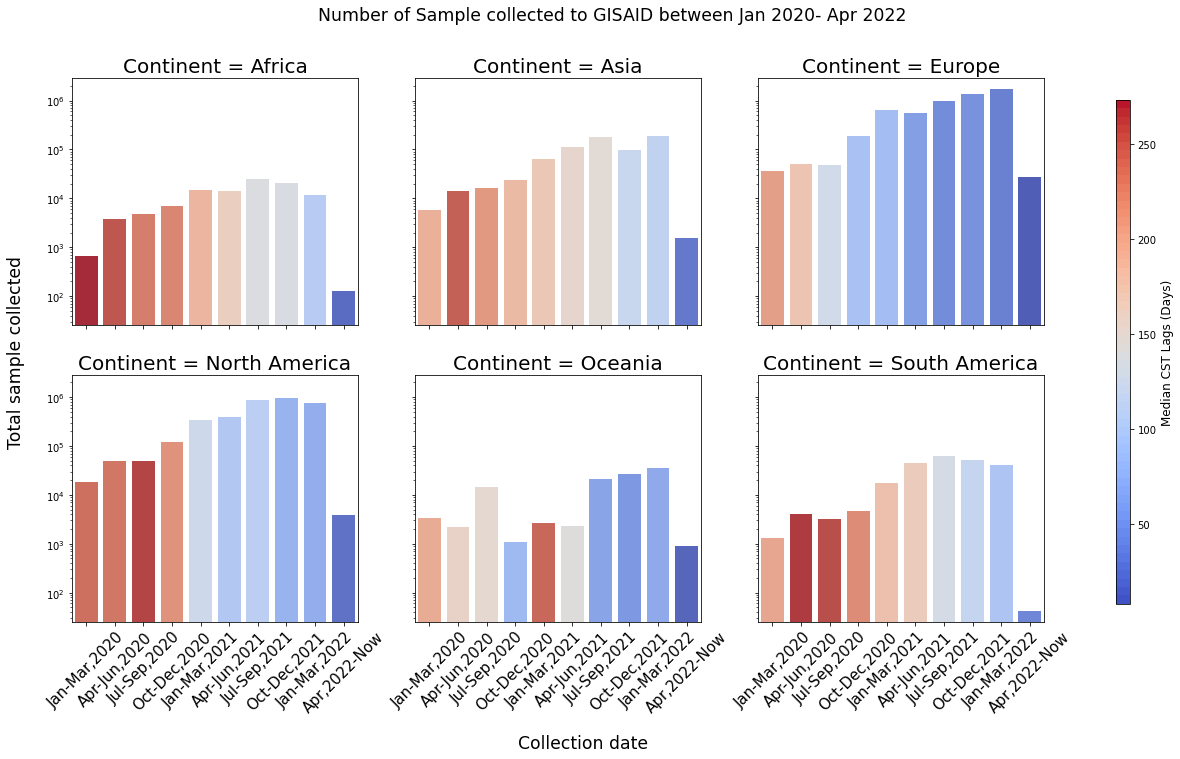

In [5]:
fig = gisaid_visualisation.Barplot().plot(
    full_data_continent_by_month,
    separateby='Continent',
    colorby='Lags median',
    x='Collection date',
    y='Lags count',
    title='Number of Sample collected to GISAID between Jan 2020- Apr 2022',
    xticklabels=[
        '-'.join([
            pd.to_datetime(i).strftime('%b'),
            (pd.to_datetime(i) + relativedelta(months=2)).strftime('%b,%Y')
        ]) for i in full_data_continent_by_month['Collection date'].unique()
    ][:-1] + [
        '-'.join([
            pd.to_datetime(full_data_continent_by_month['Collection date'].
                           unique()[-1]).strftime('%b,%Y'), 'Now'
        ])
    ],
    ylabel_pos=(.08, .5),
    xlabel_pos=(.48, -0.05),
    xlabel_fontdict={'fontsize': 15})

fig.savefig('./output_plots/Total_sample_collected_by_continent.png',
            format='png',
            dpi=300, bbox_inches='tight')

In [7]:
total_sample_per_country = full_data.groupby(['Country']).agg({'Lags':'count'}).sort_values(by='Lags',ascending=False)

In [8]:
top_countries_of_interest = total_sample_per_country.head(9).index.tolist()
full_data_top_country_by_month = gisaid_visualisation.Barplot(
).groupby_for_barplot(full_data[full_data['Country'].isin(top_countries_of_interest)].copy(),
                      groupby=['Country',pd.Grouper(freq='3MS',key='Collection date')],
                      aggby={'Lags': ['count', 'mean']},
                      date_start='2020-01-01',
                      date_end='2022-05-01')

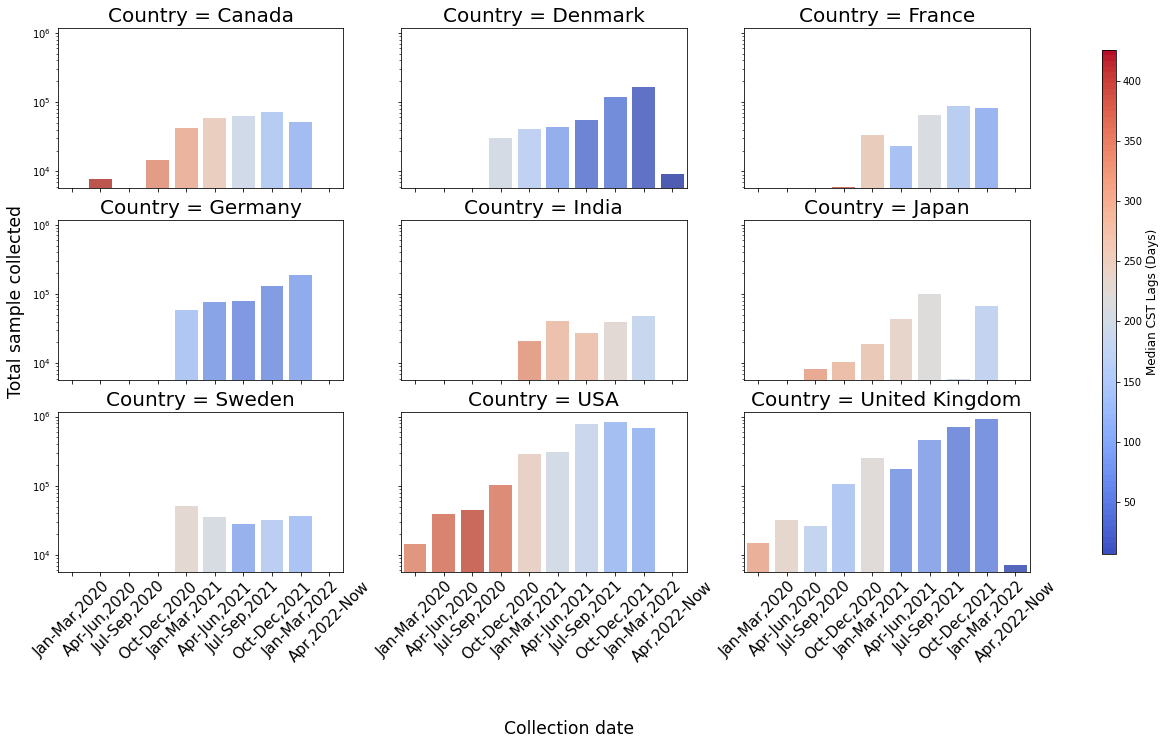

In [15]:
fig = gisaid_visualisation.Barplot().plot(
    full_data_top_country_by_month,
    separateby='Country',
    colorby='Lags mean',
    x='Collection date',
    y='Lags count',
    figsize=(20, 10),
    ylabel_pos=(.09, .5),
    xlabel_pos=(.48, -0.1),
    xticklabels=[
        '-'.join([
            pd.to_datetime(i).strftime('%b'),
            (pd.to_datetime(i) + relativedelta(months=2)).strftime('%b,%Y')
        ]) for i in full_data_continent_by_month['Collection date'].unique()
    ][:-1] + [
        '-'.join([
            pd.to_datetime(full_data_continent_by_month['Collection date'].
                           unique()[-1]).strftime('%b,%Y'), 'Now'
        ])
    ], yscalelog=True, xlabel_fontdict={'fontsize': 15})

fig.savefig('./output_plots/Total_sample_collected_by_countries.png',format='png',dpi=300,bbox_inches='tight')

## Plot 2: Comparing two regions

In [11]:
def compare_two_contients(region1,region2):
    data = full_data[((full_data['Country']==region1) | (full_data['Country']==region2))
                & (full_data['Collection_Date'] >= '2021-01-01')]
    f,ax = plt.subplots(1,1,figsize=(20,8))
    g = sns.violinplot(x='Collection_Month',y='Lags',hue='Country',data=data,scale='area',split=True,inner='quartiles',ax=ax)

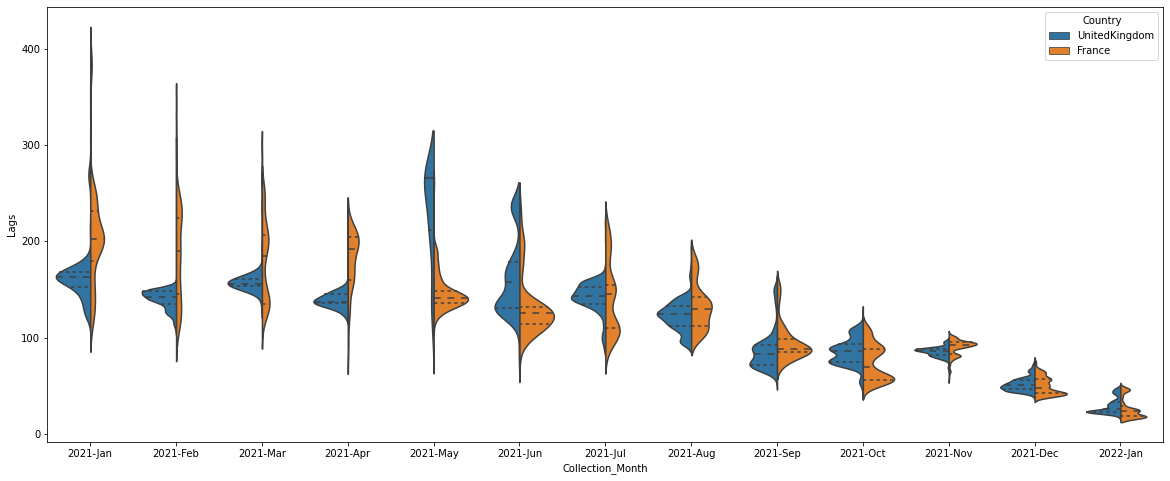

In [12]:
compare_two_contients('UnitedKingdom','France')

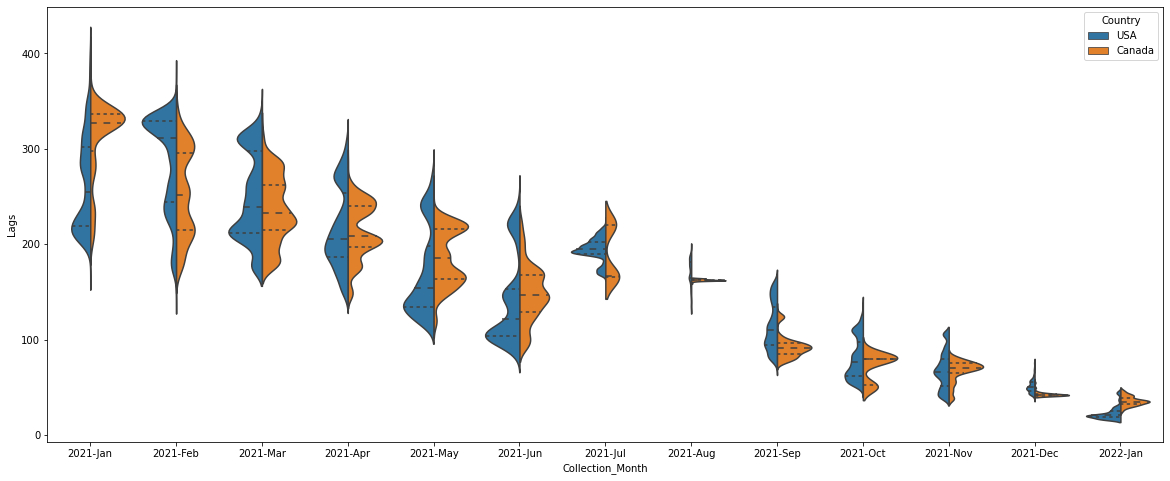

In [13]:
compare_two_contients('USA','Canada')

## Plot 3: Categorical point plots

In [28]:
all_countries = full_data.groupby(['Continent', 'Collection_Month',
                                   'Country']).agg({'Lags': np.median})

In [161]:
def return_all_dates_as_category(df, start,end,formatt='%Y-%b'):
    return pd.Categorical(df,
              categories = pd.date_range(start,end,freq='M').strftime(formatt), ordered=True)

In [72]:
all_date = return_all_dates_as_category('2020-03-01','2022-02-01')

In [8]:
all_countries['Collection_Month'] = return_all_dates_as_category(all_countries['Collection_Month'],
                                                                '2020-03-01','2022-02-01')

In [106]:
full_data_countries_by_month = gisaid_visualisation.Barplot().groupby_for_barplot(full_data,
                                                  groupby=['Continent','Country','Collection_Month'],
                                                  aggby={'Lags':['count','mean']})

In [157]:
#get the top 5 countries for each continent
total_count_per_country_by_continent = full_data_countries_by_month.groupby(
    ['Continent', 'Country']).agg({'Lags count': sum})
total_count_per_country_by_continent = total_count_per_country_by_continent.sort_values(
    by='Lags count', ascending=False).groupby('Continent').apply(
        lambda x: x.head(3)).droplevel(0)
from collections import defaultdict

countries_of_interest = defaultdict(list)
for k, v in total_count_per_country_by_continent.index.values:
    countries_of_interest[k].append(v)

In [163]:
full_data['Collection_Month'] = return_all_dates_as_category(
    full_data['Collection_Month'], '2020-01-01', '2022-04-01')

Text(0.5, 0.98, 'Change in Lags between Jan 2020 - Mar 2022 ')

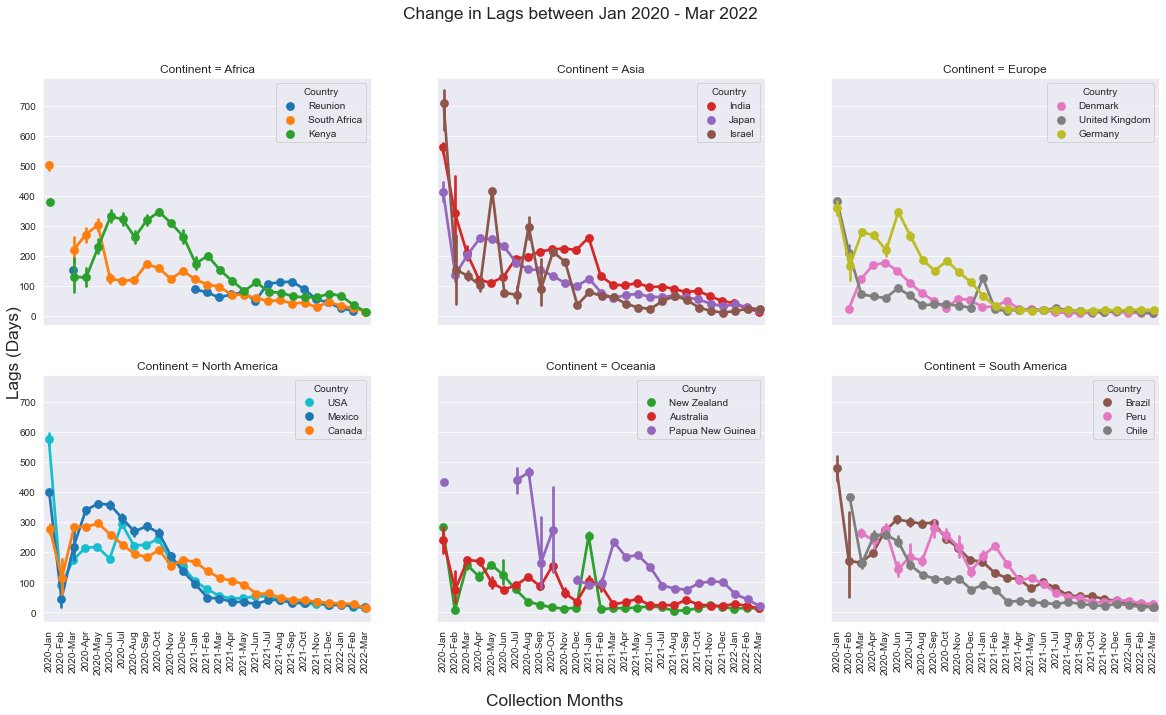

In [166]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()
pal = sns.color_palette('tab10',
                        sum(len(v) for v in countries_of_interest.values()))
pallete = np.array(pal)
for idx, continent in enumerate(countries_of_interest.keys()):
    countries_of_interest_df = full_data[(full_data['Country'].isin(
        countries_of_interest[continent]))]
    pallete_used = pallete[0:len(countries_of_interest[continent])]
    g = sns.pointplot(x='Collection_Month',
                      y='Lags',
                      data=countries_of_interest_df,
                      kind='point',
                      hue='Country',
                      ax=axes[idx],
                      dodge=True,
                      palette=pallete)
    pallete = pallete[len(countries_of_interest[continent]):]
    axes[idx].set_title(f'Continent = {continent}')
    axes[idx].set(xlabel=None)
    axes[idx].set(ylabel=None)
    if idx >= 3:
        g.set_xticklabels(g.get_xticklabels(), rotation=90)

fig.text(0.48, 0.01, 'Collection Months', ha='center', size='xx-large')
fig.text(0.1,
         0.5,
         'Lags (Days)',
         va='center',
         rotation='vertical',
         size='xx-large')
fig.suptitle('Change in Lags between Jan 2020 - Mar 2022 ', size='xx-large')

## Plot 4: Choropleth map

In [3]:
import urllib, json

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
response = urllib.request.urlopen(url)
geodata = json.loads(response.read())

In [4]:
all_countries = full_data.groupby(['Country', 'Collection_Month'
                                   ]).agg({'Lags': np.median})
Lagmap_all_countries = gisaid_visualisation.Lagmap(all_countries)
m = Lagmap_all_countries.plot_choropleth(geodata)
m

In [51]:
all_countries = all_countries.unstack()
example_df = pd.DataFrame(
    columns=all_countries.columns,
    index=pd.MultiIndex.from_product(
        [all_countries.index.get_level_values(0).unique().tolist(), all_date]))
all_countries = all_countries.reindex(example_df.index, axis=0)
all_countries = all_countries.stack()

all_countries = all_countries.reset_index()
all_countries.columns = ['Continent', 'Collection_Month', 'Country', 'Lags']

In [62]:
# m.save(outfile='./dataset/preprocessed_data/All_TimeSliderChoropleth.html')

In [87]:
countries_of_interest = ['USA', 'Canada', 'Mexico']
countries_of_interest_df = full_data[
    (full_data['Country'].isin(countries_of_interest))
    & (full_data['Collection_Date'] >= '2020-04-01')]

## Plot 5: Submission/Collection by date by country

In [4]:
UK_ex_first_day = full_data[full_data['Country'] == 'United Kingdom'].copy()

In [5]:
UK_ex_first_day = UK_ex_first_day[~UK_ex_first_day['Collection date'].isin(
pd.date_range('2020','2022-01-01',freq='1YS').strftime('%Y-%m-%d').tolist())]

In [7]:
full_data_country_by_date = gisaid_visualisation.Barplot().groupby_for_barplot(UK_ex_first_day,
                                                  groupby=['Country','Collection date'],
                                                  aggby={'Lags':['count']})

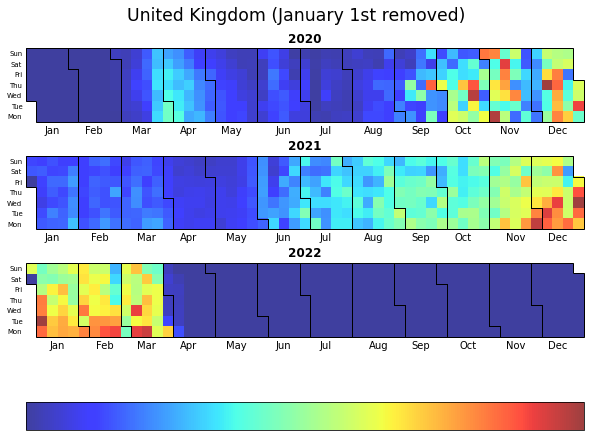

In [8]:
fig, axes = plt.subplots(3,1,subplot_kw=dict(xlim=[0,53],
                                            ylim=[0,7],frameon=False,aspect=1),figsize=(10,8))
for year,ax in zip([2020,2021,2022],axes):
    df1 = full_data_country_by_date[(full_data_country_by_date['Country']=='United Kingdom')&
                         (full_data_country_by_date['Collection date']<=str(year+1))&
                         (full_data_country_by_date['Collection date']>str(year))].copy()
    im = gisaid_visualisation.Calmap(year,
                                     df1.set_index('Collection date')[['Lags count']]).calmap(ax)
cbar = fig.colorbar(im,ax = axes.flatten(),orientation='horizontal')
cbar.set_ticks([])
fig.text(0.5,0.90, 'United Kingdom (January 1st removed)', ha='center', size='xx-large')
fig.savefig('./output_plots/UK_ex_Jan_collection_date.png',format='png',transparent=True,dpi=300,bbox_inches='tight')

In [8]:
from sklearn.preprocessing import MinMaxScaler

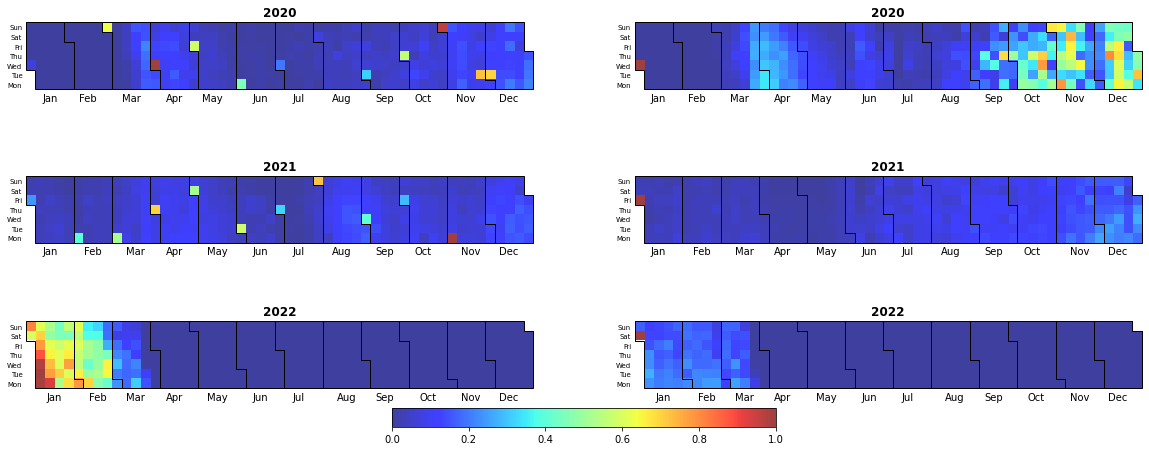

In [22]:
fig, axes = plt.subplots(3,2,subplot_kw=dict(xlim=[0,53],
                                            ylim=[0,7],frameon=False,aspect=1),figsize=(20,8))
for year,ax in zip([2020,2021,2022],axes):
    df1 = full_data_country_by_date[(full_data_country_by_date['Country']=='Canada')&
                         (full_data_country_by_date['Collection date']<=str(year+1))&
                         (full_data_country_by_date['Collection date']>str(year))].copy()
    df1['Lags count'] = MinMaxScaler().fit_transform(np.array(df1['Lags count']).reshape(-1,1))
    df2 = full_data_country_by_date[(full_data_country_by_date['Country']=='United Kingdom')&
                         (full_data_country_by_date['Collection date']<=str(year+1))&
                         (full_data_country_by_date['Collection date']>str(year))].copy()
    df2['Lags count'] = MinMaxScaler().fit_transform(np.array(df2['Lags count']).reshape(-1,1))
    im = gisaid_visualisation.Calmap(year,
                                     df1.set_index('Collection date')[['Lags count']]).calmap(ax[0])
    im = gisaid_visualisation.Calmap(year,
                                     df2.set_index('Collection date')[['Lags count']]).calmap(ax[1])
cbar = fig.colorbar(im,ax = ax,orientation='horizontal')

## Plot 6: Comparison between countries violin plot

[This Nature paper](https://www.nature.com/articles/s41587-021-01040-0) describe the lag in COVID submission to GISAID.

Key findings:
- Data is collated until 27 May 2021
- Calculated median lag for each country.
- Of the countries with over 1000 submitted genomes (54 countries), UK has the shortest time- 16 days for 417 k genomes.
- Europe - 25 days for 590 k, US- 26 for 498 k, Canada- 88 for 44k, New Zealand - 40 for 1k , Australia 51 for 17k.
- Asia - mean 72 for 89k, Singapore, 26 for 2405.


Since then:

- Countries with over 1000 submitted genomes (106 countries)
- Countries with over 5000 submitted genomes (57 countries)
- Countries with over 10000 submitted genomes (49 countries)
- Countries with over 50000 submitted genomes (24 countries)
- Countries with over 100000 submitted genomes (15 countries)

In [67]:
total_lag_per_country = gisaid_visualisation.Barplot().groupby_for_barplot(
    full_data,
    groupby=['Country','Continent'],
    aggby={'Lags': ['count', 'mean', 'median']},
    date_start='2020-01-01',
    date_end='2020-04-30')

In [60]:
total_lag_per_continent = gisaid_visualisation.Barplot().groupby_for_barplot(
    full_data,
    groupby=['Continent'],
    aggby={'Lags': ['count', 'mean', 'median']},
    date_start='2020-01-01',
    date_end='2020-04-30')

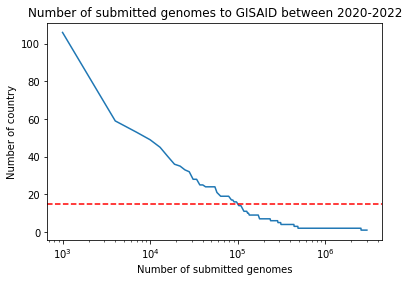

In [65]:
x = np.linspace(1000,3000000,1000)
plt.plot(x,
        [len(total_lag_per_country[total_lag_per_country['Lags count']>total]) for total in x],'-')
plt.xscale('log')
plt.xlabel('Number of submitted genomes')
plt.ylabel('Number of country')
plt.title('Number of submitted genomes to GISAID between 2020-2022')
plt.axhline(y=15,color='r',linestyle='--')

In [68]:
top_countries = total_lag_per_country.loc[total_lag_per_country['Lags count']>100000].sort_values(by='Lags median')['Country'].tolist()

Violin plot illustrating the collection to submission lag value for the 15 countries that have submitted over 100 000 genomes to GISAID

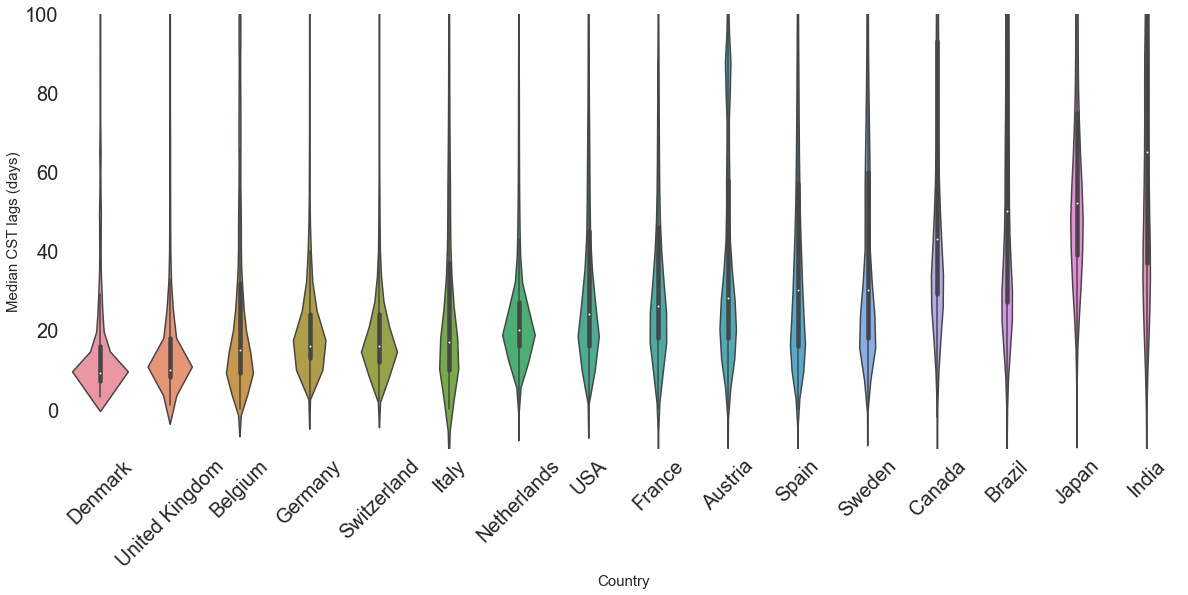

<Figure size 432x288 with 0 Axes>

In [87]:
sns.set_style('white')
f,ax = plt.subplots(1,1,figsize=(20,8))
ax.set(ylim=(-10,100))
g = sns.violinplot(x='Country',
                   y='Lags',
                   data=full_data[full_data['Country'].isin(top_countries)],
                   ax = ax,
                   inner='box',
                   order=top_countries)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
ax.tick_params(axis='both',labelsize=20)
g.set_xlabel('Country',fontsize=15)
g.set_ylabel('Median CST lags (days)',fontsize=15)
sns.despine(left=True,right=True, bottom=True,top=True)
plt.show()
plt.tight_layout()
f.savefig('./output_plots/violin_plot.png',transparent=False,format='png',bbox_inches="tight",dpi=300)

In [9]:
test = full_data[(full_data['Collection date']>'2021')&
                                 (full_data['Collection date']<'2022')].copy()

In [6]:
test['Collection_Month'] = gisaid_visualisation.Barplot().convert_to_category(test['Collection_Month'],'2021-01-01','2022-01-01')

In [10]:
test.sort_values(by=['Continent','Collection_Month'],inplace=True)

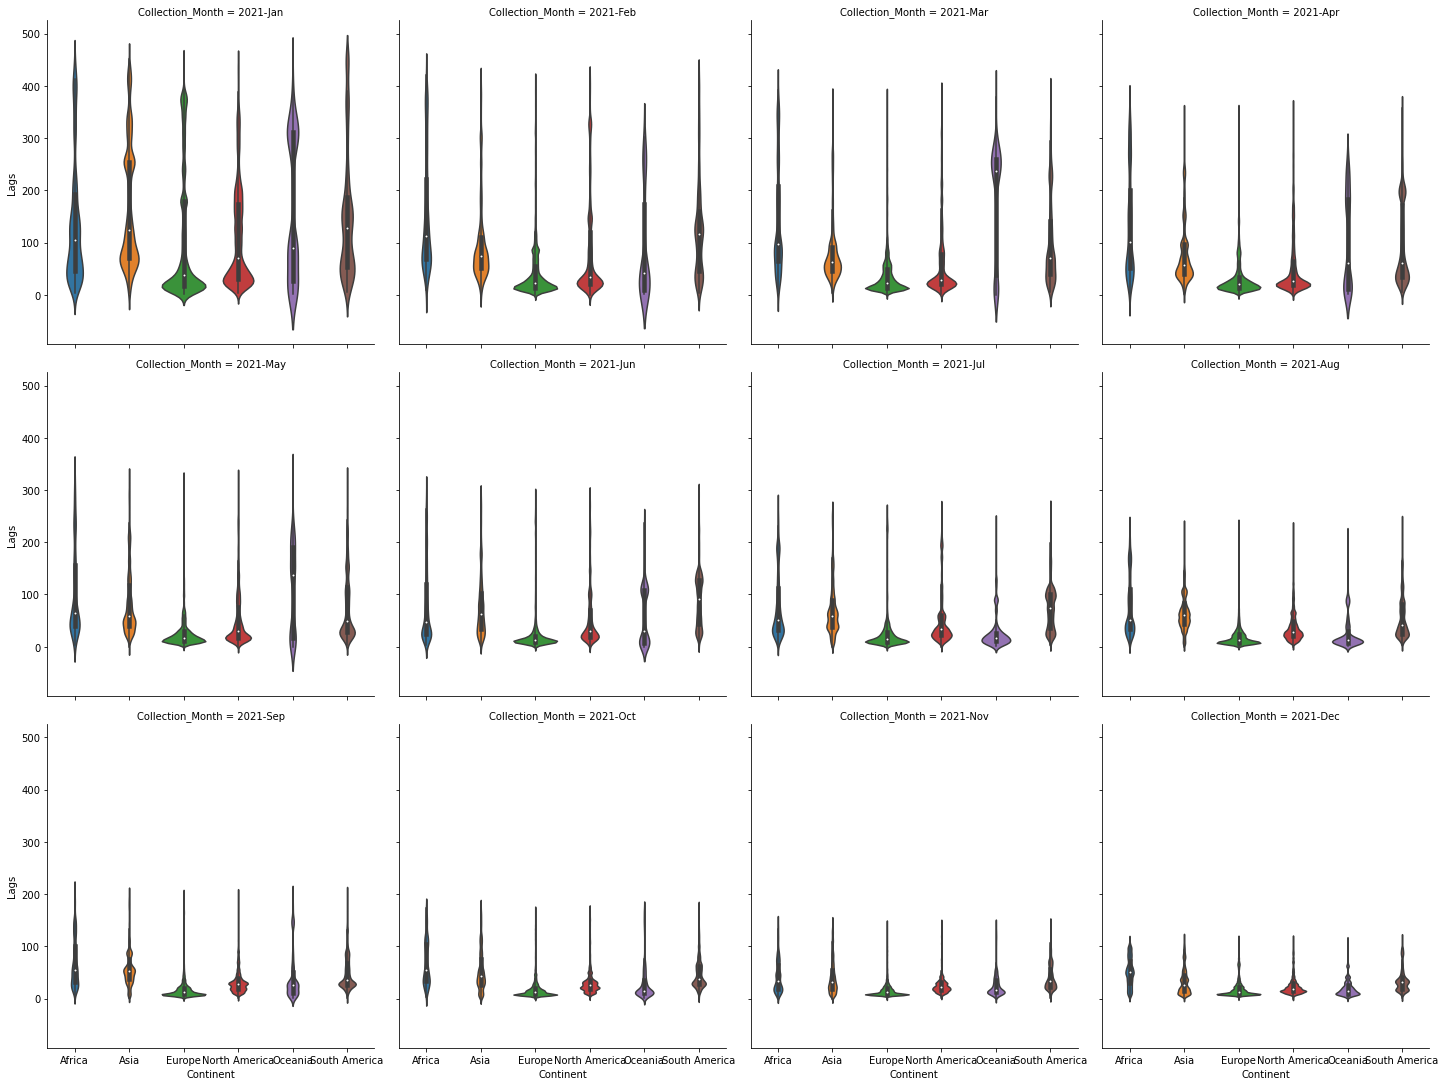

In [12]:
# f,ax = plt.subplots(1,1,figsize=(20,8))
g = sns.catplot(x='Continent',
                   y='Lags',
                   col = 'Collection_Month',col_wrap=4,
                   data=test,
                   kind='violin')

## Plot 7: Rate of sequencing

In [8]:
world_cases = pd.read_excel('./dataset/Worldometer_19_04_2022.xlsx',usecols = [1,2,3,4])

In [48]:
world_cases.columns = ['Country','Total Cases','Total Tests','Population']

In [49]:
world_cases.replace('UK','United Kingdom',inplace=True)
world_cases.replace('S. Korea','South Korea',inplace=True)
world_cases.replace('Czechia','Czech Republic',inplace=True)
world_cases.replace('UAE','United Arab Emirates',inplace=True)
world_cases.replace('DRC','Democratic Republic of the Congo',inplace=True)
world_cases.replace('Ivory Coast',"Cote d'Ivoire",inplace=True)
world_cases = world_cases.set_index('Country')

In [50]:
total_lag_per_country = gisaid_visualisation.Barplot().groupby_for_barplot(
    full_data,
    groupby=['Country', 'Continent'],
    aggby={'Lags': ['count', 'mean', 'median']},
    date_start='2020-01-01',
    date_end='2020-04-30')

top_countries = total_lag_per_country.loc[
    total_lag_per_country['Lags count'] > 100000].sort_values(
        by='Lags median')['Country'].tolist()

In [51]:
total_lag_per_country = total_lag_per_country.set_index('Country')[['Continent','Lags count']]

In [52]:
total_lag_per_country = total_lag_per_country[~total_lag_per_country.index.duplicated(keep='first')]

In [53]:
world_cases = pd.concat([world_cases,total_lag_per_country],axis=1).dropna()

In [54]:
world_cases_continent = world_cases.groupby('Continent').agg({'Total Cases':'sum',
                                     'Population':'sum',
                                     'Lags count':'sum'})

In [55]:
world_cases_continent['Rate of sequencing per positive cases'] = (world_cases_continent['Lags count'] / world_cases_continent['Total Cases']) * 100
world_cases_continent['Rate of sequencing per 1M pop'] = (world_cases_continent['Lags count'] / world_cases_continent['Population']) * 1000000

In [207]:
world_cases_continent

,Total Cases,Population,Lags count,Rate of sequencing per positive cases,Rate of sequencing per 1M pop
Continent,,,,,
Africa,11339653.0,1.318459e+09,89642.0,0.790518,67.989967
Asia,144680472.0,4.616255e+09,707970.0,0.489333,153.364577
Europe,188420364.0,7.596196e+08,5514334.0,2.926613,7259.335795
North America,97214507.0,5.882953e+08,3521858.0,3.622770,5986.547800
Oceania,6489120.0,4.253768e+07,107599.0,1.658145,2529.498315
South America,56757021.0,4.386487e+08,227246.0,0.400384,518.059267


In [56]:
world_cases['Rate of sequencing per positive cases'] = (world_cases['Lags count'] / world_cases['Total Cases']) * 100
world_cases['Rate of sequencing per 1M pop'] = (world_cases['Lags count'] / world_cases['Population']) * 1000000

In [98]:
world_cases.sort_values(by='Rate of sequencing per positive cases',ascending=False).head(16)

,Total Cases,Total Tests,Population,Lags,Rate of sequencing per positive cases,Rate of sequencing per 1M pop
Country,,,,,,
Sint Maarten,9920.0,62056.0,43749.0,2326.0,23.447581,53166.929530
Gibraltar,17494.0,534283.0,33673.0,3029.0,17.314508,89953.375108
Denmark,2952251.0,127083216.0,5828800.0,468733.0,15.877139,80416.723854
United Kingdom,21863944.0,512140269.0,68525857.0,2695929.0,12.330479,39341.777221
Luxembourg,230991.0,4205548.0,644246.0,25458.0,11.021209,39515.961294
Gambia,11994.0,155686.0,2538398.0,1303.0,10.863765,513.315879
Papua New Guinea,43663.0,249149.0,9251011.0,4530.0,10.374917,489.676209
Montserrat,177.0,9587.0,4997.0,18.0,10.169492,3602.161297
Aruba,34345.0,177885.0,107579.0,3167.0,9.221138,29438.830999


In [111]:
(world_cases[(world_cases['Population']> 100000000)
            & (world_cases['Rate of sequencing per 1M pop'])]).sort_values('Population')

,Total Cases,Total Tests,Population,Lags,Rate of sequencing per positive cases,Rate of sequencing per 1M pop
Country,,,,,,
Egypt,515645.0,3693367.0,1.057963e+08,1869.0,0.362459,17.666016
Philippines,3683367.0,29308300.0,1.121976e+08,14865.0,0.403571,132.489425
Ethiopia,470305.0,4746224.0,1.200700e+08,627.0,0.133318,5.221953
Japan,7402533.0,45879318.0,1.257818e+08,260630.0,3.520822,2072.080084
Mexico,5727832.0,15717303.0,1.313631e+08,58610.0,1.023249,446.167789
Russia,18092791.0,273400000.0,1.460467e+08,16551.0,0.091478,113.326736
Bangladesh,1952412.0,13936400.0,1.676332e+08,5837.0,0.298964,34.820077
Brazil,30279270.0,63776166.0,2.152705e+08,132775.0,0.438501,616.782276
Nigeria,255670.0,5036813.0,2.153014e+08,6011.0,2.351078,27.919004


In [58]:
world_cases_top_countries = world_cases.loc[top_countries]

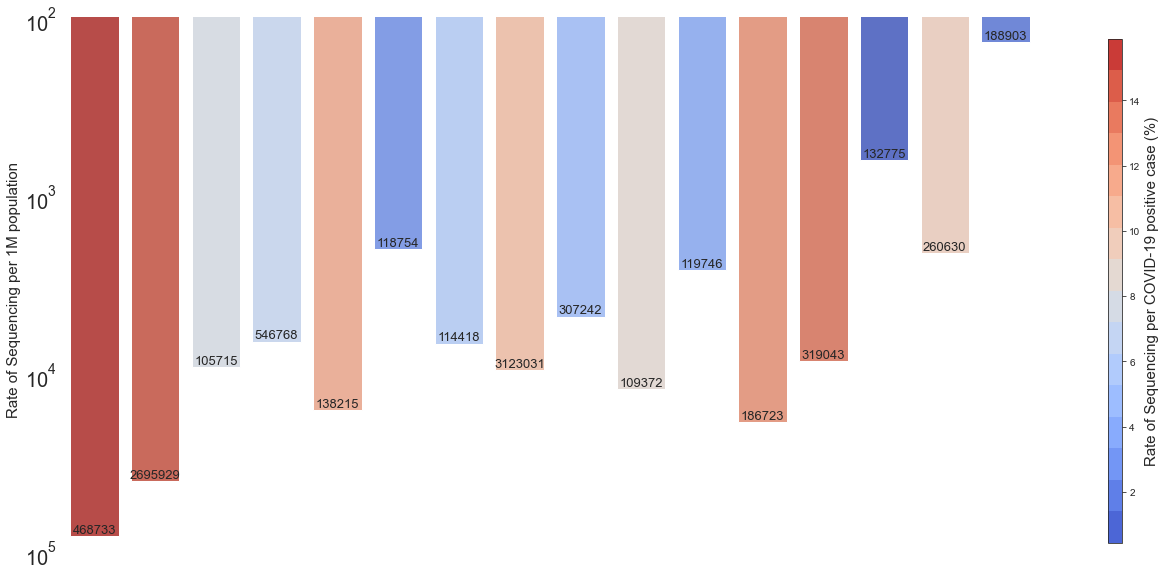

In [86]:
sns.set_style('white')
fig,ax = plt.subplots(1,1,figsize=(20,10))
all_cases = world_cases_top_countries['Rate of sequencing per positive cases'].values
pal = sns.color_palette('coolwarm', len(all_cases))
rank = all_cases.argsort().argsort()
my_cmap = ListedColormap(pal)
norm = plt.Normalize(all_cases.min(), all_cases.max())
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
pallete = np.array(pal)
plt.yscale('log')
g = sns.barplot(x=world_cases_top_countries.index,
            y='Rate of sequencing per 1M pop',
            data=world_cases_top_countries,
            palette=pallete[rank],order=top_countries,ax=ax)
g.invert_yaxis()
g.bar_label(g.containers[0],labels = [int(i) for i in world_cases_top_countries.Lags.tolist()],fontsize=13)
g.set_xlabel(None)
g.set_ylabel('Rate of Sequencing per 1M population',fontsize=15)
ax.tick_params(axis='y',labelsize=20)

fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = g.figure.colorbar(sm, cax=cbar_ax)
cbar.set_label('Rate of Sequencing per COVID-19 positive case (%)', size=15)
sns.despine(left=True,right=True, bottom=True,top=True)
g.set(xticklabels=[])
fig.savefig('./output_plots/barplot_with_violin.png',transparent=False,dpi=300,bbox_inches="tight")